In [1]:
import os

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import DBSCAN
from sklearn.metrics import pairwise_distances
from kneed import KneeLocator

from utils.models import Dataset, SplitDataset

Reading the data and merging it in one pandas dataframe, since we are essentially doing data exploration

In [19]:
train_set_umap = pd.read_csv(os.getenv('train_original_umap_X'), index_col=0)
val_set_umap = pd.read_csv(os.getenv('val_original_umap_X'), index_col=0)
test_set_umap = pd.read_csv(os.getenv('test_original_umap_X'), index_col=0)

train_set_original = pd.read_csv(os.getenv('TRAIN_SET_ORIGINAL_PATH'), index_col=0, header=[0, 1, 2])
val_set = pd.read_csv(os.getenv('VALIDATION_SET_PATH'), index_col=0, header=[0, 1, 2])
test_set = pd.read_csv(os.getenv('TEST_SET_PATH'), index_col=0, header=[0, 1, 2])

genre_column = ('genre', 'Unnamed: 253_level_1', 'Unnamed: 253_level_2')
train_y = train_set_original[genre_column]
val_y = val_set[genre_column]
test_y = test_set[genre_column]

We will not utilize the genre column, since it is subjectvie (assigned by the authors themselves) and may lead to wrong conclusions about the data. In fact it may not even be the case that the genres come up naturally with the clustering.

*A reminder that the UMAP dimensionality reduction was done with min_dist=0.0, which is appropriate for clustering*

In [20]:
print(train_set_umap.shape, val_set_umap.shape, test_set_umap.shape)

(21572, 15) (2397, 15) (5993, 15)


In [79]:
df = pd.concat([train_set_umap, val_set_umap, test_set_umap], axis=0)
df_y = pd.Series(pd.concat([train_y, val_y, test_y], axis=0), name='genre')

In [80]:
df = df.iloc[:500]
df_y = df_y.iloc[:500]

In this notebook we will be using the DBSCAN algorithm, and since it is a density based algotighm, it can suffer from the curse of dimensionality, which is the reason why we use the UMAP - reduced dataset.
The algorithm is approrpiate in our case since it does not make assumptions about the shapes of the clusters.
About the hyperparameters, *MinPts* should generally be greater than or equal to the dimensionality of the data set, so In our case we could try using *MinPts=30*.

About the chouce of $\epsilon$, we will calcualte the average distance between each point and it's 30 (*MinPts*) nearest neighbors. We will then plot these distances in ascending order and choose the value for $\epsilon$ that is at the point of maximum curvature on the plot (i.e. where the graph has the greatest slope-knee)


# Parameter Choosing

In [38]:
MIN_SAMPLES = 30

In [39]:
def calculate_distances(X, metric):
    return pd.DataFrame(pairwise_distances(X, metric=metric, n_jobs=5), index=X.index, columns=X.index)

In [40]:
df_distances = calculate_distances(df, 'euclidean')

In [41]:
top_30_closest_df = pd.DataFrame(df_distances.apply(lambda row: row.nsmallest(MIN_SAMPLES).values, axis=1).tolist())

In [42]:
mean_distances = top_30_closest_df.mean(axis=1).sort_values(ascending=True)

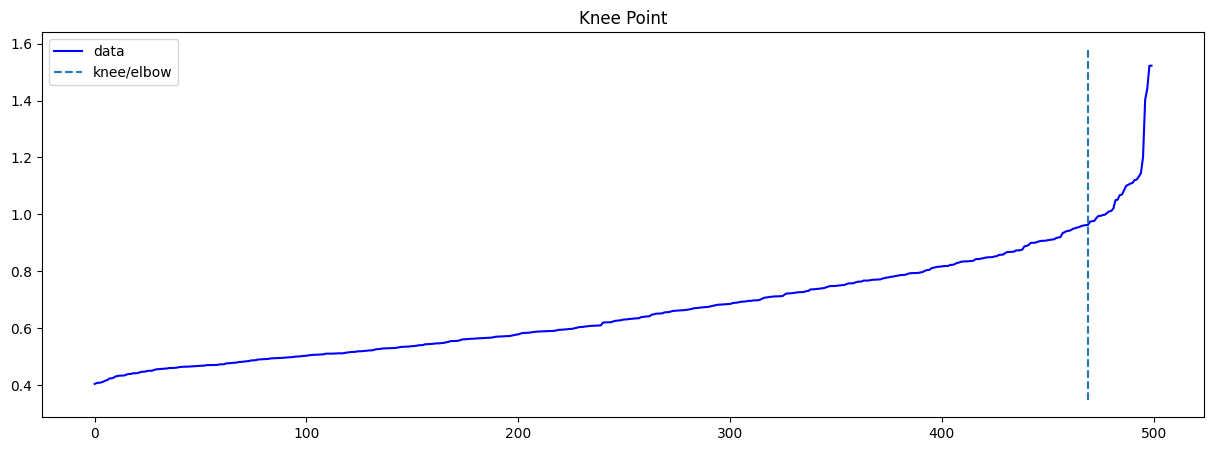

In [43]:
kl = KneeLocator(range(len(mean_distances)), mean_distances, curve="convex")
kl.plot_knee(figsize=(15, 5))

In [44]:
epsilon = kl.elbow_y

# Clustering

In [45]:
dbscan = DBSCAN(eps=epsilon, min_samples=30, metric='euclidean')

In [46]:
dbscan.fit(df)

DBSCAN(eps=0.9628169623050424, min_samples=30)

In [81]:
clusters = pd.Series(dbscan.labels_, index=df.index, name='cluster')

In [82]:
df_complete = pd.concat([
    df,
    df_y,
    clusters
], axis=1)

In [117]:
cluster_by_genre = df_complete.groupby(['genre', 'cluster']).size().reset_index(name='count')

In [118]:
cluster_by_genre.index = pd.MultiIndex.from_tuples(sorted(list(set(zip(cluster_by_genre['genre'], cluster_by_genre['cluster'])))), names=['Genre', 'Cluster'])

In [119]:
cluster_by_genre.drop(['genre', 'cluster'], axis=1)

count
Genre               Cluster       
Blues                0           2
Classical            0           9
                     2           1
Country              0           1
Electronic          -1          14
                     0          15
                     1          15
                     2          68
Experimental        -1          10
                     0          20
                     1          16
                     2          26
Folk                -1           1
                     0          27
                     2           1
Hip-Hop             -1           2
                     0           3
                     1           6
                     2          42
Instrumental        -1           1
                     0          18
                     1           1
                     2           5
International        0           3
                     2           6
Jazz                -1           1
                     0           4
                     1           1
                     2           2
Old-Time / Historic -1           3
                     0           4
Pop                 -1           2
                     0           5
                     1           9
                     2           6
Rock                -1          11
                     0          14
                     1         107
                     2          13
Soul-RnB             2           3
Spoken               1           1
                     2           1

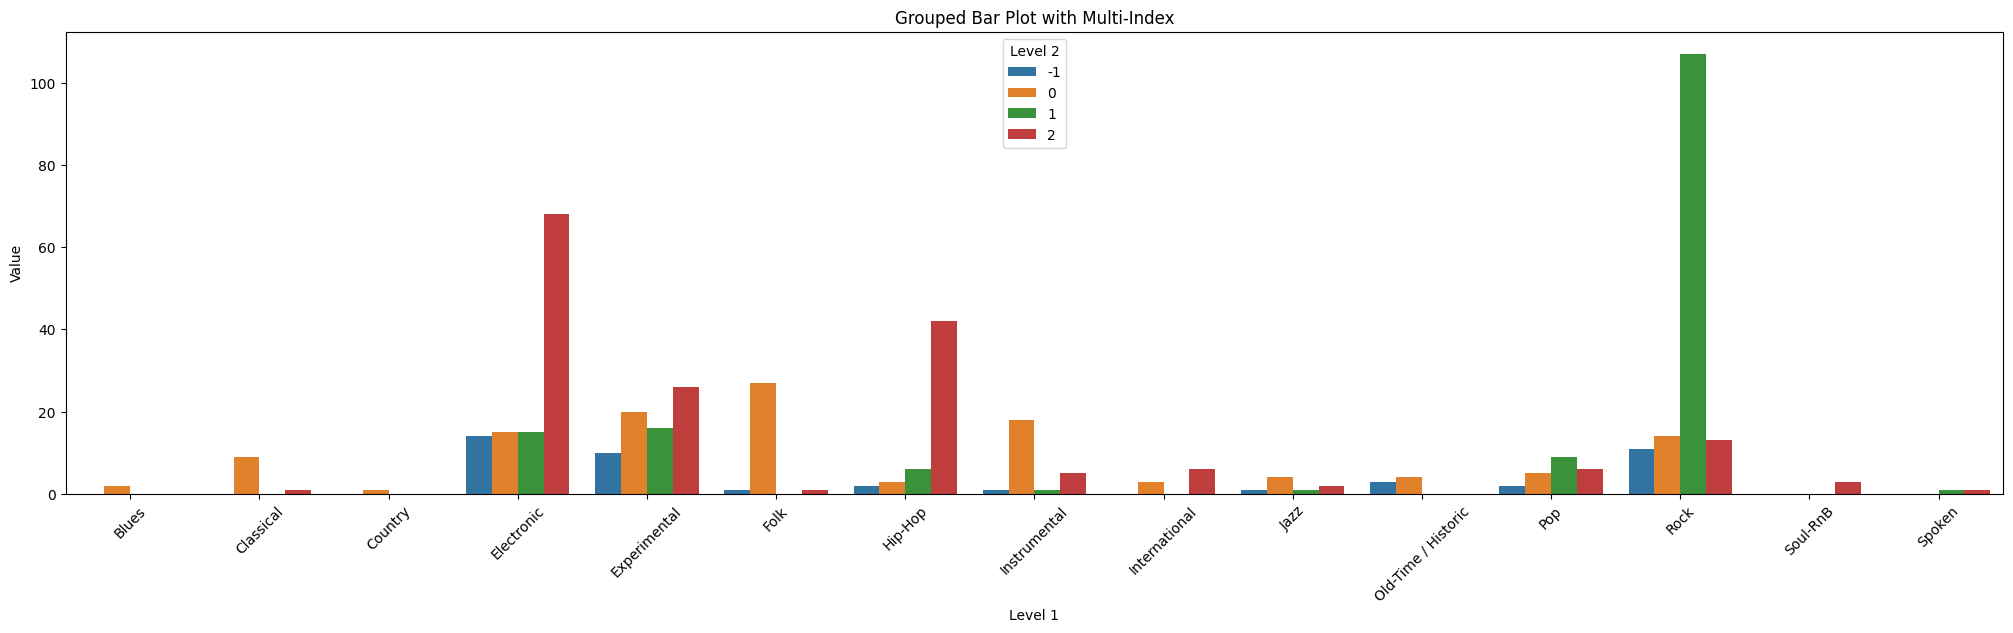

In [124]:
plt.figure(figsize=(25, 6))
sns.barplot(x='genre', y='count', hue='cluster', data=cluster_by_genre.reset_index(drop=True))
plt.xlabel('Level 1')
plt.ylabel('Value')
plt.title('Grouped Bar Plot with Multi-Index')
plt.xticks(rotation=45)
plt.legend(title='Level 2')

In [127]:
import utils.visualization_utils as vis_utils

d:\Kiril\Da Finki\6 Semestar\Податочно Рударење\PR_Labs\clone\Music-Genre-Classification\.venv\Lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning:

The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.

d:\Kiril\Da Finki\6 Semestar\Податочно Рударење\PR_Labs\clone\Music-Genre-Classification\.venv\Lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning:

The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.

In [ ]:
# original datana iskoristi ja za dim reduction da naprajs itn